In [1]:
import torch
from torch.optim import Optimizer
from sklearn import datasets
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_boston(ratio=0.8):
    X, Y = datasets.load_boston(True)
    Y.shape = -1, 1
    
    # normalization
    X = X/80
    Y = Y/(np.max(Y) - np.min(Y))
    
    num_samples = len(Y)
    num_train = math.ceil(num_samples * ratio)
    
    # 随机打乱数据
    idx = np.random.permutation(np.arange(num_samples))
    traindata = X[idx[:num_train]], Y[idx[:num_train]]
    validdata = X[idx[num_train:]], Y[idx[num_train:]]
    
    return traindata, validdata

In [3]:
class GradientDescent(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9,nesterov=False):
        # 将参数导回Optimizer，这样可以允许lr_scheduler修改lr
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov)
        
        print(defaults)
        super().__init__(params, defaults)
        
    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
        
    def step(self):
        #print('h')
        #print(self.param_groups)
        for group in self.param_groups:
            momentum = group['momentum']
            nesterov = group['nesterov']
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        b = param_state['momentum_buffer'] = torch.clone(grad).detach()
                    else:
                        b = param_state['momentum_buffer']
                        #b.mul_(momentum).add_(group['lr'], grad)
                        b.mul_(momentum).add_(1, grad)
                    if nesterov:
                        grad = grad.add(momentum, b)
                    else:
                        grad = b
                    

                p.data.add_(-group['lr'], grad)
            

In [4]:
#a=GradientDescent(lr=1e-5)

In [5]:
(X_train, Y_train), (X_valid, Y_valid) = load_boston()
X_train, Y_train = torch.Tensor(X_train), torch.Tensor(Y_train)
X_valid, Y_valid = torch.Tensor(X_valid), torch.Tensor(Y_valid)

In [6]:
model = torch.nn.Sequential(
    torch.nn.Linear(13, 50),
    torch.nn.Sigmoid(),
    torch.nn.Linear(50, 1)
)

In [7]:
loss = torch.nn.MSELoss()

In [8]:
# 使用自定义优化器
opt = GradientDescent(model.parameters(), lr=1e-5,momentum=0.99)


{'lr': 1e-05, 'momentum': 0.99, 'nesterov': False}


In [9]:
#opt.step()

In [10]:
valid_losses = []
train_losses = []
for i in range(1500):
    X, Y = X_train, Y_train
    
    opt.zero_grad()
    l = loss(model(X), Y)
    l.backward()
    opt.step()
    
    with torch.no_grad():
        cur_train_loss = l
        cur_valid_loss = loss(Y_valid, model(X_valid))
        valid_losses.append(cur_valid_loss) 
        train_losses.append(cur_train_loss)

        if i%100 == 0:
            print(f"Iter {i}: loss {cur_train_loss:.4f}, valid loss {cur_valid_loss:.4f}")
       

Iter 0: loss 0.8385, valid loss 0.8140
Iter 100: loss 0.0328, valid loss 0.0264
Iter 200: loss 0.1428, valid loss 0.1409
Iter 300: loss 0.0399, valid loss 0.0326
Iter 400: loss 0.0419, valid loss 0.0336
Iter 500: loss 0.0356, valid loss 0.0309
Iter 600: loss 0.0326, valid loss 0.0270
Iter 700: loss 0.0329, valid loss 0.0263
Iter 800: loss 0.0321, valid loss 0.0261
Iter 900: loss 0.0321, valid loss 0.0264
Iter 1000: loss 0.0320, valid loss 0.0260
Iter 1100: loss 0.0320, valid loss 0.0260
Iter 1200: loss 0.0319, valid loss 0.0261
Iter 1300: loss 0.0319, valid loss 0.0260
Iter 1400: loss 0.0319, valid loss 0.0260


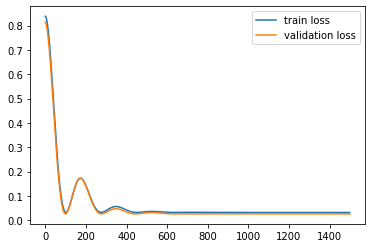

In [11]:
plt.plot(train_losses)
plt.plot(valid_losses)
plt.legend(["train loss", "validation loss"])

经过阅读torch.optim.SGD的源代码，发现pytorch实现动量的方式和提供的参考资料不一样，

 ![jupyter](./momentum.png)

其中，Nesterov是动量算法的一个变种，可以理解为在标准动量方法中添加了一个校正因子。

 ![jupyter](./nesterov.png)